전체 데이터 크기: (9021, 94)
Local Validation Score (Avg Sharpe): 0.4992
Max Volatility Ratio: 1.01 (Should be <= 1.2)


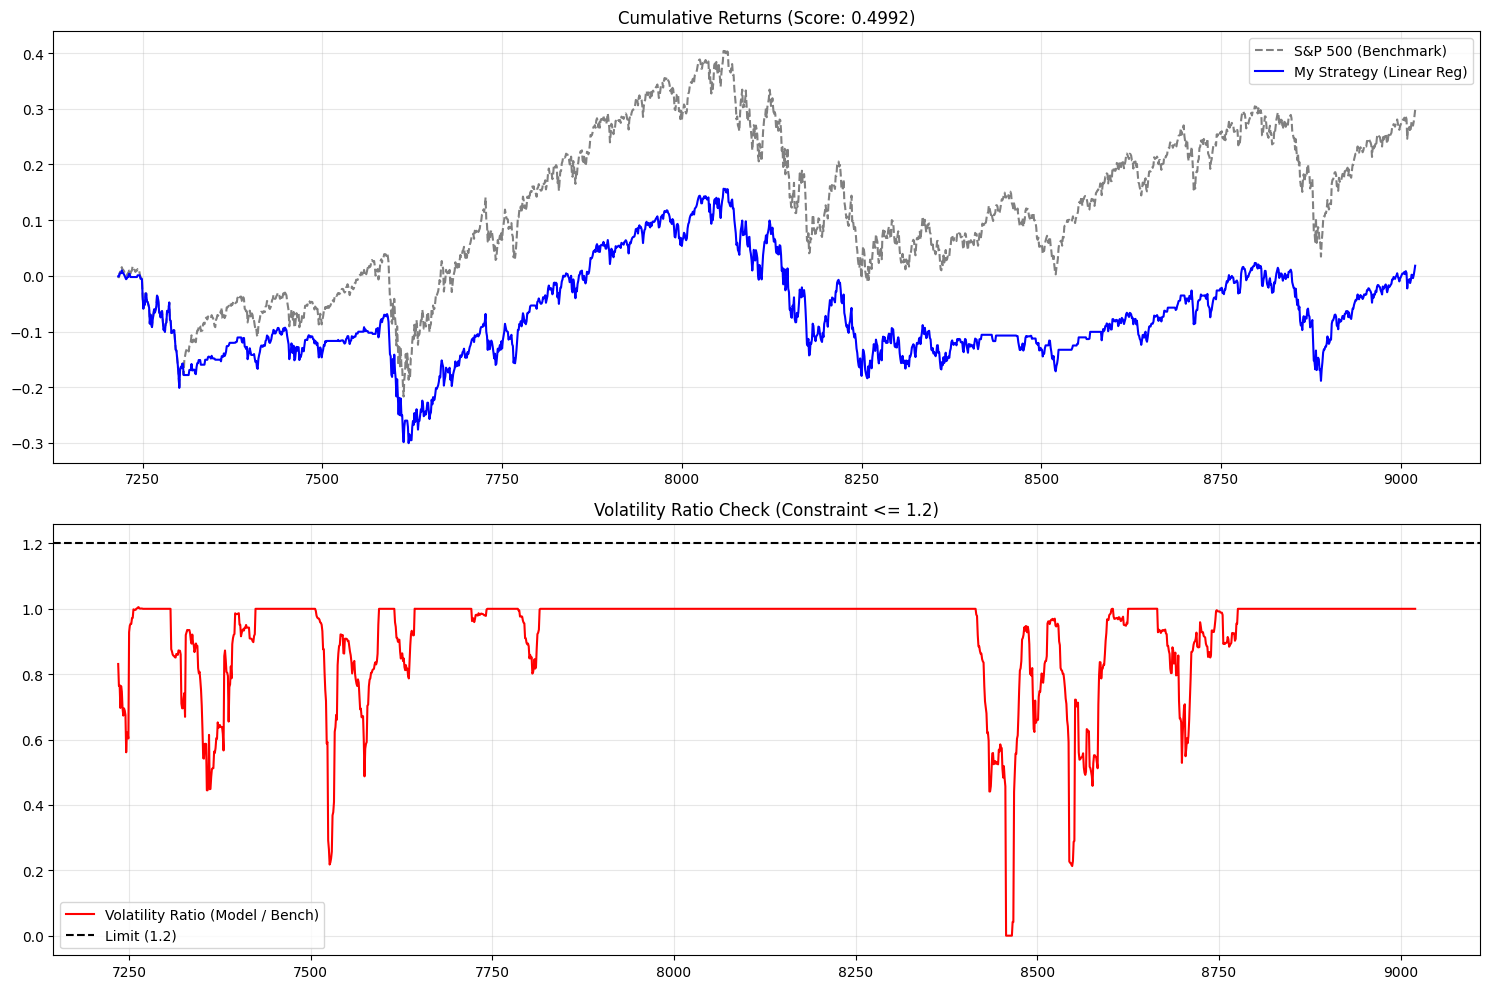

최종 모델 학습 완료!


In [3]:
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import kaggle_evaluation.default_inference_server

DATA_PATH = '/kaggle/input/hull-tactical-market-prediction/'

train = pl.read_csv(f"{DATA_PATH}train.csv")

# 타겟 변수
target_col = 'market_forward_excess_returns'

drop_cols = [
    'date_id', 'forward_returns', 'risk_free_rate', 
    'market_forward_excess_returns', 'is_scored', 
    'lagged_forward_returns', 'lagged_risk_free_rate', 
    'lagged_market_forward_excess_returns'
]

# 사용할 피처 이름만 뽑아내기
feature_cols = [c for c in train.columns if c not in drop_cols]


X_data = train.select(feature_cols).cast(pl.Float64, strict=False).fill_null(0).to_numpy()
X_data = np.nan_to_num(X_data, nan=0.0, posinf=0.0, neginf=0.0)

y_data = train.select(target_col).to_numpy().flatten()
y_data = np.nan_to_num(y_data, nan=0.0, posinf=0.0, neginf=0.0)

dates = train.select('date_id').to_numpy().flatten()

print(f"전체 데이터 크기: {X_data.shape}")


#뒤쪽 20%를 검증 데이터로 사용
split_idx = int(len(X_data) * 0.8)

X_train_val = X_data[:split_idx]
y_train_val = y_data[:split_idx]

X_test_val = X_data[split_idx:]
y_test_val = y_data[split_idx:]
dates_test_val = dates[split_idx:]

# 검증용 모델 학습
val_model = LinearRegression()
val_model.fit(X_train_val, y_train_val)

# 검증용 예측
val_raw_preds = val_model.predict(X_test_val)

# 전략 적용 (양수면 1, 아니면 0)
val_signals = np.where(val_raw_preds > 0, 1.0, 0.0)

# 분석용 데이터프레임 생성
analysis_df = pd.DataFrame({
    'date_id': dates_test_val,
    'benchmark_return': y_test_val,       # 시장 수익률
    'my_signal': val_signals              # 내 모델의 투자 비중
})

# 전략 수익률 계산 (비중 * 시장수익률)
analysis_df['strategy_return'] = analysis_df['my_signal'] * analysis_df['benchmark_return']

# 1. 누적 수익률 (Cumulative Return)
analysis_df['cum_bench'] = (1 + analysis_df['benchmark_return']).cumprod() - 1
analysis_df['cum_strat'] = (1 + analysis_df['strategy_return']).cumprod() - 1

# 2. 변동성 비율 (Volatility Ratio)
window_vol = 20
analysis_df['roll_vol_bench'] = analysis_df['benchmark_return'].rolling(window_vol).std()
analysis_df['roll_vol_strat'] = analysis_df['strategy_return'].rolling(window_vol).std()
# 0으로 나누는 것 방지
analysis_df['vol_ratio'] = analysis_df['roll_vol_strat'] / (analysis_df['roll_vol_bench'] + 1e-8)

# 3. Local Sharpe-variant Score (간이 계산)
# 연율화 계수
SQRT_252 = np.sqrt(252)
sharpe_window = 60

# 롤링 샤프 지수 계산
analysis_df['roll_sharpe_strat'] = (
    analysis_df['strategy_return'].rolling(sharpe_window).mean() / 
    (analysis_df['strategy_return'].rolling(sharpe_window).std() + 1e-8)
) * SQRT_252

# 전체 기간 평균 샤프 점수
avg_local_sharpe = analysis_df['roll_sharpe_strat'].mean()

print(f"Local Validation Score (Avg Sharpe): {avg_local_sharpe:.4f}")
print(f"Max Volatility Ratio: {analysis_df['vol_ratio'].max():.2f} (Should be <= 1.2)")

# --- 시각화 (리포트용 그래프) ---
plt.figure(figsize=(15, 10))

# 그래프 1: 누적 수익률 비교
plt.subplot(2, 1, 1)
plt.plot(analysis_df['date_id'], analysis_df['cum_bench'], label='S&P 500 (Benchmark)', color='gray', linestyle='--')
plt.plot(analysis_df['date_id'], analysis_df['cum_strat'], label='My Strategy (Linear Reg)', color='blue')
plt.title(f'Cumulative Returns (Score: {avg_local_sharpe:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 그래프 2: 변동성 비율 (리스크 관리 확인용)
plt.subplot(2, 1, 2)
plt.plot(analysis_df['date_id'], analysis_df['vol_ratio'], color='red', label='Volatility Ratio (Model / Bench)')
plt.axhline(1.2, color='black', linestyle='--', label='Limit (1.2)')
plt.title('Volatility Ratio Check (Constraint <= 1.2)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_report.png') # 이미지 파일로 저장
plt.show() # 화면 출력


# 4. 최종 제출용 모델 재학습 (전체 데이터)
model = LinearRegression()
model.fit(X_data, y_data) # 전체 데이터로 다시 학습
print("최종 모델 학습 완료!")

# 5. 예측 함수 정의
def predict(test: pl.DataFrame):
    # 테스트 데이터도 학습 때와 똑같이 강력 세척
    X_test = test.select(feature_cols).cast(pl.Float64, strict=False).fill_null(0).to_numpy()
    
    # NaN/Inf 제거
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 예측
    if X_test.shape[0] == 0:
        return 0.0
        
    pred_return = model.predict(X_test)[0]
    
    # 단순 베팅 전략 (양수면 1, 음수면 0)
    if pred_return > 0:
        return 1.0
    else:
        return 0.0

# 6. 제출 시스템 가동
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (DATA_PATH,)
    )